In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

from scipy import stats
import wfdb
from wfdb.processing import normalize_bound

import confmain
from util_module import util_func
from util_module.ecg_signal import ECGSignal

In [2]:
record_number = "10"

curr_dir = os.getcwd()
data_dir = os.path.join(curr_dir, '../data/ludb')
record_dir = os.path.join(data_dir, record_number)

record = wfdb.rdrecord(record_dir)
dict_record = record.__dict__

record_annot = wfdb.rdann(record_dir, 'hea')
dict_record_annot = record_annot.__dict__

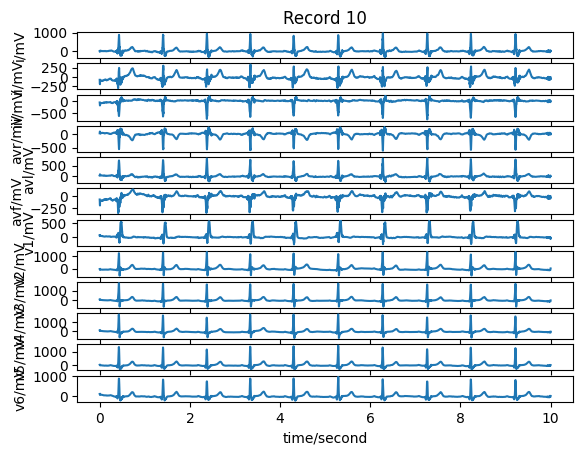

In [3]:
wfdb.plot_wfdb(record=record, title=f'Record {record_number}')

In [4]:
dict_record

{'record_name': '10',
 'n_sig': 12,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': ['<age>: 79',
  '<sex>: F',
  '<diagnoses>:',
  'Electric axis of the heart: left axis deviation.',
  'Complete right bundle branch block.',
  'Left atrial hypertrophy.',
  'Scar formation: inferior wall.'],
 'sig_name': ['i',
  'ii',
  'iii',
  'avr',
  'avl',
  'avf',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6'],
 'p_signal': array([[ -11.99216644,  -71.99666428,  -59.9983198 , ...,  109.99699835,
           11.9980585 ,  105.0085693 ],
        [ -55.00539152, -152.00370722,  -96.99321048, ...,   72.00148942,
          -16.9881601 ,   77.00382436],
        [ -40.00031715, -180.00133506, -140.00626255, ...,   81.99430827,
          -16.9881601 ,   79.99247303],
        ...,
        [  15.00507437,  -30.00022251,  -44.99873985, ..., -100.00417951,
          -52.00067625,  -39.99623652],
        [ -29.99032698,  -57.00139

In [5]:
dict_record['p_signal'][:, 0]

array([-11.99216644, -55.00539152, -40.00031715, ...,  15.00507437,
       -29.99032698,  -6.99708224])

In [6]:
dict_record['p_signal'][0]

array([-11.99216644, -71.99666428, -59.9983198 ,  41.99540304,
        24.00829283, -65.99665585,  62.00551131, -40.00521549,
        59.99443312, 109.99699835,  11.9980585 , 105.0085693 ])

In [7]:
dict_record_annot

{'record_name': '10',
 'extension': 'hea',
 'sample': array([    49,    337,    387,    440,    488,    541,    589,   1114,
          1163,   1209,   1306,   1594,   1648,   1701,   1747,   2055,
          2109,   2410,   2975,   3285,   4094,   4715,   4747,   4779,
          5067,   5628,   6446,   6494,   7051,   7357,   7667,   7699,
          7987,   8512,   8561,   8607,   8704,   8992,   9046,   9095,
          9658,  10221,  10530,  10826,  10876,  11698,  12507,  13128,
         13160,  13192,  13480,  13793,  14097,  14385,  14946,  15257,
         15289,  15577,  15938,  16204,  16764,  17120,  17236,  17797,
         18341,  18906,  19470,  19782,  20078,  20390,  20950,  21759,
         22380,  22412,  22444,  22732,  23040,  23095,  23383,  23944,
         24001,  24053,  24101,  24462,  24823,  25089,  25649,  26005,
         26121,  26682,  27482,  28045,  28607,  29425,  29721,  30283,
         30593,  31402,  32023,  32055,  32087,  32375,  33196,  33248,
         33

In [8]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [9]:
dict_record_annot['sample'].shape

(414,)

In [10]:
set(dict_record_annot['symbol'])

{'*',
 '+',
 '/',
 '?',
 'A',
 'B',
 'D',
 'E',
 'L',
 'Q',
 'R',
 'T',
 '^',
 'j',
 nan,
 'p',
 't',
 'u',
 '~'}

In [11]:
wfdb.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed QRS detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


## Denoise

In [12]:
#Frequency sample
fs = dict_record['fs']

signal = dict_record['p_signal'][:, 1]
wavelet = 'coif5'
level = 7

denoised_signal = util_func.denoise_dwt(signal, wavelet, level)

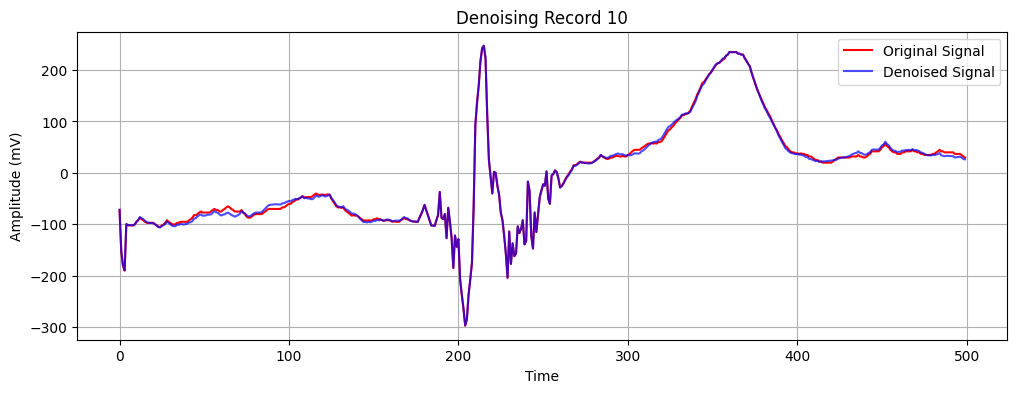

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(signal[:fs], label='Original Signal', color='red')
plt.plot(denoised_signal[:fs], label='Denoised Signal', color='blue', alpha=0.7)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude (mV)')
plt.title(f'Denoising Record {record_number}')
plt.grid(True)
plt.show()

## Normalize

Normalize them to [0, 1]

In [14]:
normalized_signal = normalize_bound(denoised_signal)

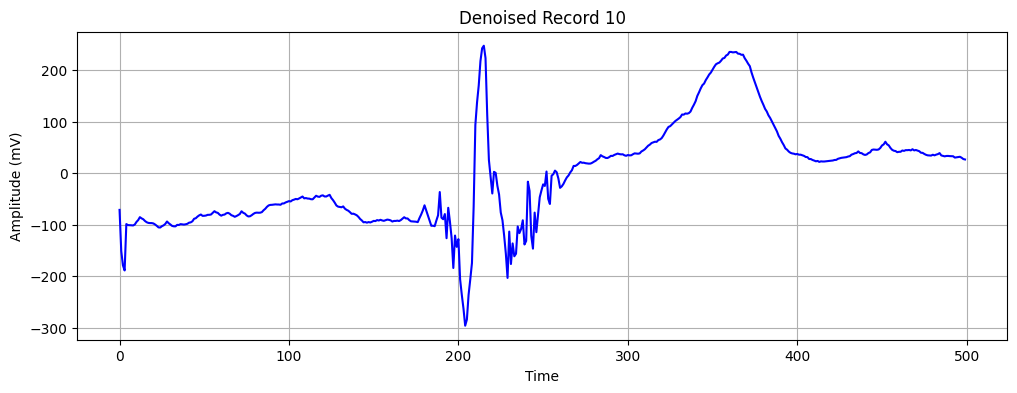

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(denoised_signal[:fs], label='Denoised Signal', color='blue')
plt.xlabel('Time')
plt.ylabel('Amplitude (mV)')
plt.title(f'Denoised Record {record_number}')
plt.grid(True)
plt.show()

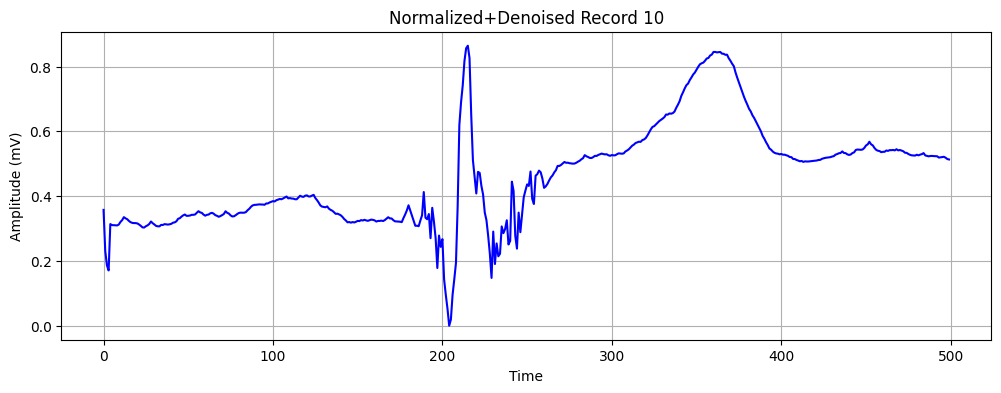

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(normalized_signal[:fs], label='Denoised+Normalized Signal', color='blue')
plt.xlabel('Time')
plt.ylabel('Amplitude (mV)')
plt.title(f'Normalized+Denoised Record {record_number}')
plt.grid(True)
plt.show()

## Segmentation

c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


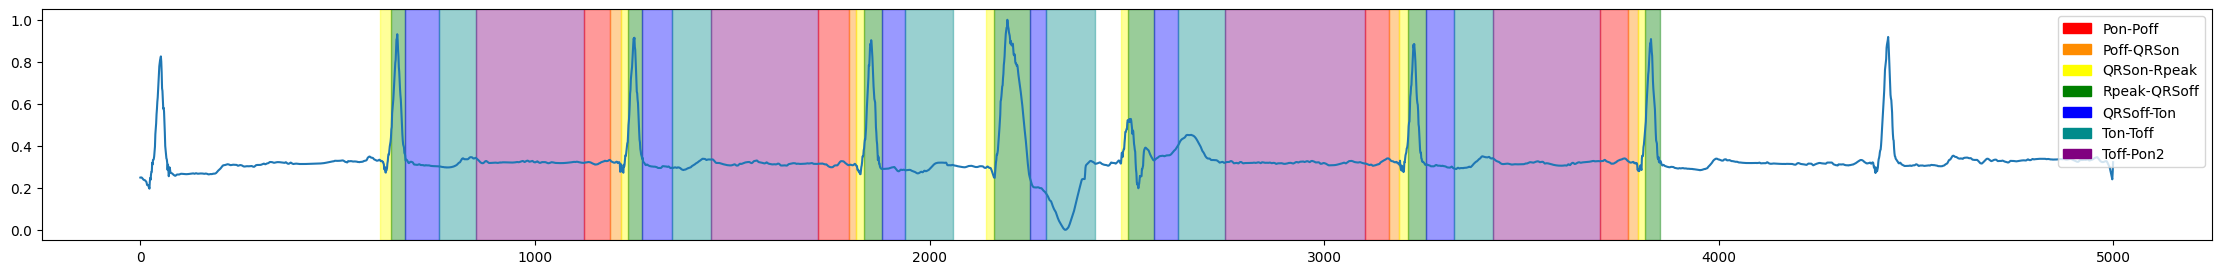

In [17]:
ecg = ECGSignal.load_ecg_signal(125, 'atr_ii')

ecg.plot_segments()

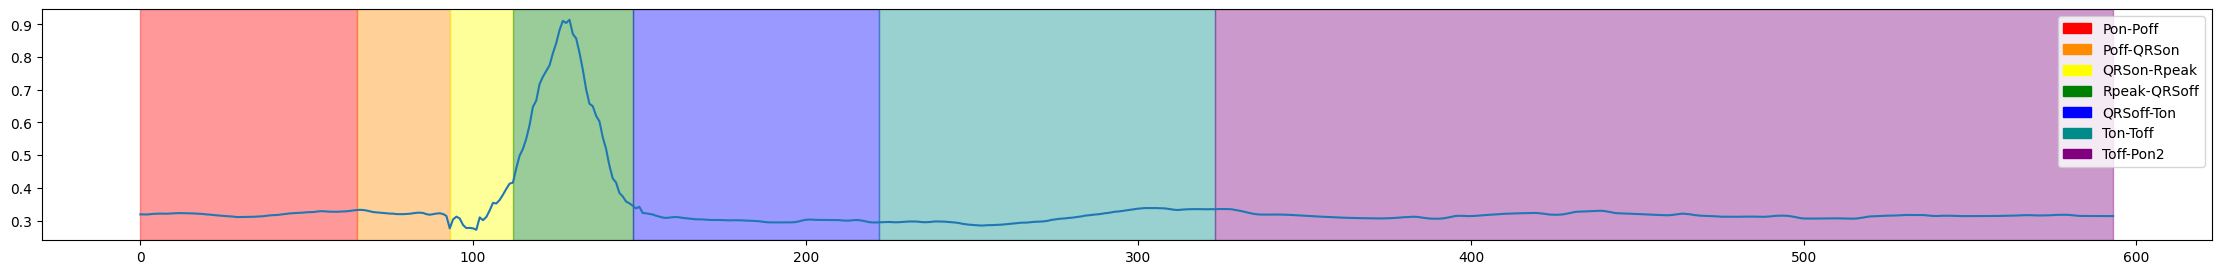

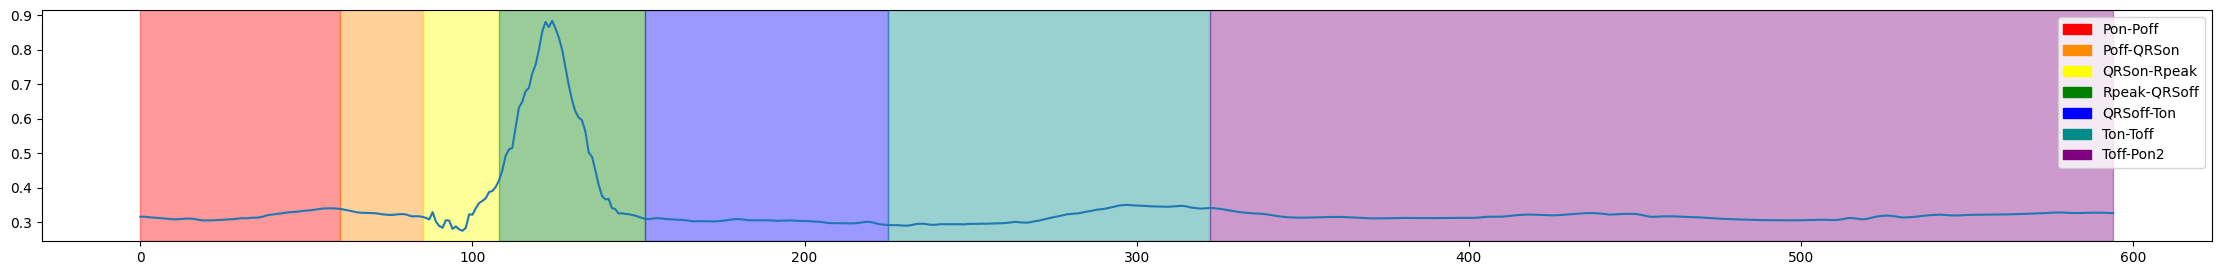

In [18]:
ecg_beats = ecg.cut_per_beat()

# plot record 125 lead ii normal beats
for signal, segment_map in ecg_beats:
    ECGSignal.plot_signal_segments(signal, segment_map)

## Extracting features and labels

In [19]:
# LEADS = ['atr_avf', 'atr_avl', 'atr_avr', 'atr_i', 'atr_ii', 'atr_iii', 'atr_v1', 'atr_v2', 'atr_v3', 'atr_v4', 'atr_v5', 'atr_v6']
LEADS = ['atr_i', 'atr_ii', 'atr_iii']
# LEADS = ['atr_iii']

longest_beat = 0

# Find the longest beat for zero padding
for ecg_index in range(1, 201):
    for lead in LEADS:
        s = ECGSignal.load_ecg_signal(ecg_index, lead)
        beats = s.cut_per_beat()

        for beat in beats:
            signal, _ = beat
            longest_beat = max(longest_beat, len(signal))

            if(longest_beat == len(signal)):
                info_longest_beat = (ecg_index, lead)

c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 i

In [20]:
print(longest_beat)
print(info_longest_beat)

781
(66, 'atr_iii')


In [21]:
features = []
labels = []

for record_num in range(1, 201):
    for lead in LEADS:
        try:
            s = ECGSignal.load_ecg_signal(record_num, lead)

            for beat in s.cut_per_beat():
                signal, segment_map = beat
                signal = np.array(signal)
                segment_map = np.array(segment_map)

                # Zero padding
                pad_length = longest_beat - len(signal)

                signal = np.pad(signal, (0, pad_length), mode='constant', constant_values=0)
                segment_map = np.pad(segment_map, (0, pad_length), mode='constant', constant_values=0)

                segment_map = to_categorical(segment_map, num_classes=8)

                features.append((signal, pad_length))
                labels.append(segment_map)

        except:
            # Print failed instance
            print(f"Record: {record_num} | Lead: {lead}", end=' , ')

c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\dev\ecg-delineation\env\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 i

In [22]:
len(features)

3668

In [23]:
final_data = {
    'features' : features,
    'labels' : labels
}
data_save_path = '../data/ludb_processed'
util_func.make_dir(data_save_path)
# Uncomment and run to generate a new one
# util_func.save_file(f'{data_save_path}/ludb_i_ii_iii.pickle', final_data)